# Homework 3 Part 2

## Course Name: Deep Learning
#### Lecturers: Dr. Beigy

---

#### Notebooks Supervised By: Zeinab Sadat Taghavi
#### Notebooks Prepared By: Zahra Khoramnejad, Mehran Sarmadi, Zahra Rahimi

**Contact**: Ask your questions in Quera

---

### Instructions:
- Complete all exercises presented in this notebook.
- Ensure you run each cell after you've entered your solution.
- After completing the exercises, save the notebook and <font color='red'>follow the submission guidelines provided in the PDF.</font>


---


#Text Generation

<p align='justify'>Text generation task involves generating new text based on a given input or a prompt. It is a natural language processing (NLP) task that aims to generate coherent and contextually relevant text.

In text generation, a model is trained on a large corpus of text data and learns the patterns and structures of the language. This model can then be used to generate new text by sampling from the learned distribution of words or characters.

Text generation has various applications, including chatbots, language translation, poetry generation, and content creation. It can be implemented using different techniques such as `recurrent neural networks (RNNs)`, `transformers`, and `Markov chains`.

The goal of text generation is to produce text that is fluent, coherent, and contextually relevant. It requires a deep understanding of the language and the ability to generate text that follows grammatical rules and maintains semantic coherence.</p>

## Charachter-leve l text generation

One stage of the task of text generation is mapping, which can be at the word or character level. At this stage, a number is assigned to each word or character.

In this exercise, we generate text at the character level. Because generating text at the word level, even though it leads to more meaningful outputs, requires a rich dataset with a high number of word repetitions.

We will implement models based on `recurrent networks` for text generation and compare the performance of different models. In the following, we will check the performance of the best models on different datasets and compare the results

The steps of this exercise are as follows:
1. Train RNN and LSTM
2. FineTuning
3. Experiment on different datasets

---
---

#1. Train RNN and LSTM

## Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical

import numpy as np
import pandas as pd
import random
import re
import string

import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
# The function is supported from torch 2.0
if torch.set_default_device != None:
  torch.set_default_device(device)

## Load data

- We use the dataset of `Shakespeare's plays` as the main dataset for this exercise

In [3]:
!wget "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt" -c -P {'data/'}

--2023-12-08 15:59:31--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 416 Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



- Load data in amout of 30kb for training models

In [4]:
sh_data_file = "./data/input.txt"
sh_data = open(sh_data_file, 'r').read(30000)

##Charachter mapping

- For better performance of the model, we limit the set of allowed characters

In [5]:
chars = list(string.ascii_lowercase + '\n' + ' ' + ':' + '.')
vocab_size = len(chars)

In [6]:
# Mapping of char-index
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

##Preprocessing

In [7]:
def remove_extraneous_characters(data, valid_char_list):
    pattern = f"[^{re.escape(''.join(valid_char_list))}]"
    return re.sub(pattern, '', data)

In [8]:
sh_data = remove_extraneous_characters(sh_data.lower(), chars)
sh_data_size = len(sh_data)

# Extract indexes of data characters
sh_data = list(sh_data)
for i, ch in enumerate(sh_data):
    sh_data[i] = char_to_ix[ch]

sh_data = torch.tensor(sh_data).to(device)
sh_data = torch.unsqueeze(sh_data, dim=1)

In [9]:
sh_data

tensor([[ 5],
        [ 8],
        [17],
        ...,
        [18],
        [27],
        [ 0]], device='cuda:0')

## Modeling

- In this part define RNN and LSTM model, according to the mentioned characteristics and function inputs.


### RNN

In [10]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=512, num_layers=3, dropout_enable=False):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout_enable = dropout_enable
        self.dropout = nn.Dropout(0.5)
        self.hidden_state = None

        # Define the RNN and decoder
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input_seq):
        # Convert input sequence to one-hot encoding
        input_seq = nn.functional.one_hot(input_seq, num_classes=self.input_size).float()

        # Initialize hidden state with correct batch size if it's None
        if self.hidden_state is None or self.hidden_state.size(1) != input_seq.size(0):
            self.hidden_state = torch.zeros(self.num_layers, input_seq.size(0), self.hidden_size).to(input_seq.device)

        # Pass the input sequence and hidden state to the RNN
        output, self.hidden_state = self.rnn(input_seq, self.hidden_state)

        # Pass the output of the RNN to the decoder and apply log softmax
        output = self.decoder(output)
        output = nn.functional.log_softmax(output, dim=2)

        return output

    def save_model(self, path):
        torch.save(self.state_dict(), path)

    def load_model(self, path):
        self.load_state_dict(torch.load(path))


### LSTM

In [11]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=512, num_layers=3, dropout_enable=False):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout_enable = dropout_enable
        self.dropout = nn.Dropout(0.5)
        self.hidden_state = None

        # Define the LSTM and decoder
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input_seq):
        # Convert input sequence to one-hot encoding
        input_seq = nn.functional.one_hot(input_seq, num_classes=self.input_size).float()

        # Initialize hidden state with correct batch size if it's None
        if self.hidden_state is None or self.hidden_state[0].size(1) != input_seq.size(0):
            self.hidden_state = (torch.zeros(self.num_layers, input_seq.size(0), self.hidden_size).to(input_seq.device),
                                 torch.zeros(self.num_layers, input_seq.size(0), self.hidden_size).to(input_seq.device))

        # Pass the input sequence and hidden state to the LSTM
        output, self.hidden_state = self.lstm(input_seq, self.hidden_state)

        # Pass the output of the LSTM to the decoder and apply log softmax
        output = self.decoder(output)
        output = nn.functional.log_softmax(output, dim=2)

        return output

    def save_model(self, path):
        torch.save(self.state_dict(), path)

    def load_model(self, path):
        self.load_state_dict(torch.load(path))


## Training

In [12]:
def print_sample_output(model, data, data_size, test_output_len = 200):
    # Use this function to print sample that model generates from its current hidden state and random input character
    # test_output_len is total num of characters in output test sequence

    test_output = ""
    data_ptr = 0

    rand_index = np.random.randint(data_size-1)
    input_seq = data[rand_index : rand_index+1]

    while True:
        output = model(input_seq)

        output = F.softmax(torch.squeeze(output), dim=0)
        dist = Categorical(output)
        index = dist.sample().item()

        test_output += ix_to_char[index]

        input_seq[0][0] = index
        data_ptr += 1

        if data_ptr > test_output_len:
            break

    print("Train Sample +++++++++++++++++++++++++++++++++++++++++++++")
    print(test_output)
    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")

- For construction of each sample in the dataset, the output sequence is
obtained from the shift of one character from the input sequence. For example, when sequence_length is 10 and our text is `Hello world`. The input sequence would be `Hello worl`, and the target sequence `ello world`.

In [13]:
def train_epoch(model, data, data_size, epoch, optimizer, seq_len=200):
    model.train()
    criterion = nn.CrossEntropyLoss()
    total_loss = 0
    sample_number = 0

    for i in range(0, data_size-1-seq_len, seq_len):
        # Detach the hidden state from its history
        if model.hidden_state is not None:
            if isinstance(model, LSTM):
                model.hidden_state = (model.hidden_state[0].detach(), model.hidden_state[1].detach())
            else:
                model.hidden_state = model.hidden_state.detach()

        # Create input and target sequences
        input_seq = data[i : i+seq_len]
        target_seq = data[i+1 : i+seq_len+1]

        # Pass the input sequence to the model
        output = model(input_seq)

        # Reshape output and target sequences for loss computation
        output = output.view(-1, model.output_size)
        target_seq = target_seq.view(-1)

        # Compute the loss, backpropagate and update parameters
        loss = criterion(output, target_seq)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update total loss and sample number
        total_loss += loss.item()
        sample_number += 1

        # Print current loss and a sample output every ten epochs
        if epoch % 10 == 0 and i == 0:
            print("Epoch:", epoch, "Loss:", total_loss / sample_number)
            print_sample_output(model, data, data_size)

    return total_loss / sample_number


In [14]:
def train_rnn(data, data_size, model_save_file):
    # RNN parameters
    hidden_size = 512
    num_layers = 6
    lr = 0.002
    epoch_num = 100
    losses = []

    # Initialize the RNN model and optimizer
    model = RNN(len(char_to_ix), len(char_to_ix), hidden_size, num_layers)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    min_loss = float('inf')

    # Train the model for the specified number of epochs
    for epoch in range(1, epoch_num + 1):
        loss = train_epoch(model, data, data_size, epoch, optimizer)
        losses.append(loss)

        # Save the model if it has the lowest loss so far
        if loss < min_loss:
            min_loss = loss
            model.save_model(model_save_file)

    return losses


In [15]:
def train_lstm(data, data_size, model_save_file):
    # LSTM parameters
    hidden_size = 512
    num_layers = 3
    lr = 0.002
    epoch_num = 100
    losses = []

    # Initialize the LSTM model and optimizer
    model = LSTM(len(char_to_ix), len(char_to_ix), hidden_size, num_layers)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    min_loss = float('inf')

    # Train the model for the specified number of epochs
    for epoch in range(1, epoch_num + 1):
        loss = train_epoch(model, data, data_size, epoch, optimizer)
        losses.append(loss)

        # Save the model if it has the lowest loss so far
        if loss < min_loss:
            min_loss = loss
            model.save_model(model_save_file)

    return losses


In [16]:
assert isinstance(sh_data, torch.Tensor), "Data should be a torch tensor"
assert len(sh_data.shape) == 2, "Data should be a 2D tensor"
assert sh_data.shape[1] == 1, "Data should have shape [n, 1]"


assert len(sh_data.shape) == 2, "Input sequence should be a 2D tensor"


### RNN

In [17]:
rnn_sh_losses = train_rnn(sh_data, sh_data_size, './model_sh_rnn.pth')

Epoch: 10 Loss: 3.227360486984253
Train Sample +++++++++++++++++++++++++++++++++++++++++++++
ptkrsa

 ta hthuhewswhoietdoeinthda
art
e op:etoet ut dhhttlrtoteilcaefweo e tah :ratu
nmei
 thw.cpai th.a
me  :htr ith
otsoot u euhsdeerrbhohp hhr smgsrele:ttphe
oyilha oduadthlaeaaet
nnta oi loeteh m
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 20 Loss: 3.2294492721557617
Train Sample +++++++++++++++++++++++++++++++++++++++++++++
limdhrshge st hid chiuh 
dawi dwsiwd
os hnavhtl whhr  s.mtwgtre
n
tc mshlosttee
eootawhulhrre gosteur
emhs
ihyhee elsg m
  iie kmahhrthhhp eahl 
eid
toahhl noohr
:mtnedesohrsyuth w phe ayar tepeht.lhbr
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 30 Loss: 3.2292263507843018
Train Sample +++++++++++++++++++++++++++++++++++++++++++++
mpvrimha: owib nht:lhygxset enerdeniae ltbwhlhhatriltdhae mtok :mohaetoaseslaih teth: kio:s e httrhahwaroyh
lu thoeehe:eoau.h tikmhad  nuphieet.ep
ehtokakekd dt k  tdrtiritbe:lideh  ma wchktr
witt


### LSTM

In [18]:
lstm_sh_losses = train_lstm(sh_data, sh_data_size, './model_sh_lstm.pth')

Epoch: 10 Loss: 2.5060980319976807
Train Sample +++++++++++++++++++++++++++++++++++++++++++++
ir st
perout
lde t ho 
sievt ch
whindseer we
hetowe iukthalous t:
o meonieust the y f 
me adar s sds t irs hour:
o 
we l 
o yyorsndord aakst thyr n amashiuswhinselehalaatherod thime my lldi oren sherg 
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 20 Loss: 2.4429409503936768
Train Sample +++++++++++++++++++++++++++++++++++++++++++++
s:
ithard h wand m peyere d yond rerove a hibes:
md le arevat se athalil ur ce wim.
wo wen a yoforrce:
y. ge dithas woscomyoll hy:
ame ba.
the chux in ar watolsese icowy lyor t ius ton we pakn geyo bus
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 30 Loss: 2.0010433197021484
Train Sample +++++++++++++++++++++++++++++++++++++++++++++
 nditheind y ig ts.
mals tese ciusthe.
thed d arurk derke goferithe tererouls dindm hacore thas whermo ius fr thavandot y et bery
mmoweeyousha
tand thomu thengitho
t agt he ane.
yoerestheleriurore

##Generating texts

- A sample text to input the model

In [19]:
input_sample_text = 'First Citizen:\nYou are all resolved rather to die than to famish?\n'

def create_input_sample_dataset(input_sample_text):
    input_sample = remove_extraneous_characters(input_sample_text.lower(), chars)
    input_sample = list(input_sample)
    for i, ch in enumerate(input_sample):
        input_sample[i] = char_to_ix[ch]

    input_sample = torch.tensor(input_sample).to(device)
    input_sample = torch.unsqueeze(input_sample, dim=1)
    return input_sample

- This function generates the output generated by the model for the input sample, and if the input sample text is not given, it samples a sequence of original data and gives it to the model.

In [20]:
def generate_text(model, data, data_size, input_sample_test = None, output_len=1000):
    model.eval()
    data_ptr = 0
    test_output=""

    if input_sample_test is not None:
        index = 0
        seq_len = len(input_sample_test)
        input_seq = input_sample_test[index : index + seq_len-1]
    else:
        # If input sample not declared, select an initial string from the data of 10 characters randomly
        index = np.random.randint(data_size - 11)
        seq_len = 10
        input_seq = data[index : index + 9]

   # Set last hidden state of model by feeding input sequence to model
    output = model(input_seq)

    # Last charachter feed to model
    if input_sample_test is not None:
        input_seq = input_sample_test[index + seq_len-1 : index + seq_len]
    else:
        input_seq = data[index + seq_len-1 : index + seq_len]

    while True:
        output = model(input_seq)

        output = F.softmax(torch.squeeze(output), dim=0)
        dist = Categorical(output)
        index = dist.sample().item()

        test_output += ix_to_char[index]
        input_seq[0][0] = index
        data_ptr += 1

        if data_ptr  > output_len:
            break

    print("Eaxmple of generated text --------------------------------------------------------------------------")
    print(test_output)
    print("----------------------------------------------------------------------------------------------------")

### RNN

In [21]:
best_model_rnn =  RNN(vocab_size, vocab_size, 512, 6).to(device)
best_model_rnn.load_model('./model_sh_rnn.pth')
print("best loss", min(rnn_sh_losses))
generate_text(best_model_rnn, sh_data, sh_data_size)

best loss 3.0258850031885607
Eaxmple of generated text --------------------------------------------------------------------------

gt a he le eah
oda:kledmanseefmrtt.ih sr eydllmaoeurhhretei odh
lua  osatt uu
ewrweehe 
arhdhere aed
h  l oddu he
te ees
 rm tdhshde  tiehidh rdehllsn
dutoo huwevddte  ee

 bchhi eeehaeriie 
hwsirthotuh.thwioheshere nolo hhhoeiut y r
 aymsgghu hi: actei he feetdwehcurltew ts ro
atifh hnigfhetrwh nrhmw rtukuehe ue stwtiors tpeaehtu 
heltmatdh ttmuwargt hhe
etattd
r.edarg dtruu:lahhu 
r  hrh etraltwig.ttiad:pddrtie
 s:imi:tsi 
sfaeradeterlwntt admn
 uah tt
 m
e
woi we
rhta
t ltuihtds eiuraf s
uhiuiell 

ol:e h tkatamt etd ai
t 
 i updipdeineoahrheite
hnd rid r a hlm oheifheddktd rtt
uawltatriu
au motnnmfuheeda emadf  :ttmee:rhoeoott:eroh:coraitgttmtthttct emiaaoehutliitsrikee hdtd
enth sutathens ia  ehugr dslm
ceil
udes
wdid eteath
t ud
cti atael h oi hu eiihehg edth gm
roh ii:hi  s ehnuuh uwr:ahmarrfihoowhttteaekyn
ruhadaue  th 
de  inotg timdipmaoyriataemnd

### LSTM

In [22]:
best_model_lstm =  LSTM(vocab_size, vocab_size, 512, 3).to(device)
best_model_lstm.load_model('./model_sh_lstm.pth')
print("best loss", min(lstm_sh_losses))
generate_text(best_model_lstm, sh_data, sh_data_size)

best loss 0.28870882391929625
Eaxmple of generated text --------------------------------------------------------------------------
oour one it rsheilin yokeld oun ake yon winodeake itheds om r y id thed nia:
ma
mave dou od s meendollicowersmend nea ws.
touse tse
ne us haitrsinca nd sind outhal figithed vieno tecordf o o n hese cpl od hueno che h t nino lerunire bacoure rsheshandl mussen tuluse ste d nestiroommiu baton:
vithofare us:
nthe archy t me
fot s oucire pakyorolonsour oucirs y faliupoundiu
by r pestouniufourceicit the tmsot conestirourint r hengmand m t these dit araishendscle i ntsoure mi ooo at

oulane uchthup aiereniufan d g ge ns oucidila m y s s sealiberelye sth wh mukerimecire.
buthofaror foomugien ngiut d.
fo tase tsthese senghianthed ousthese fanertirok.

m ballery wesolu ean ghi

guthed yothese the
t
arave t t the t
a vey s e:
thes ous is ofr ouse an he

mswand
tiouriu

fous:
tithe tlld wearse soofidand monses ty y ownd thit othe imald i y t t tese thind macouss:
tli s

## Plotting the losses

In [23]:
def plot_losses(losses):
    xpoints = np.array(range(len(losses)))
    ypoints = np.array(losses)

    plt.plot(xpoints, ypoints, color='blue',label='losses')
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

### RNN

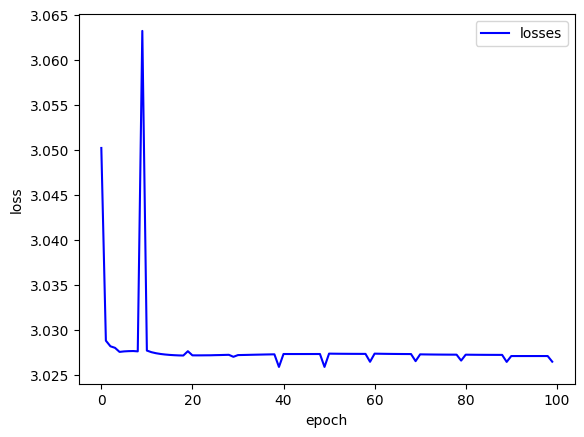

In [24]:
plot_losses(rnn_sh_losses)

### LSTM

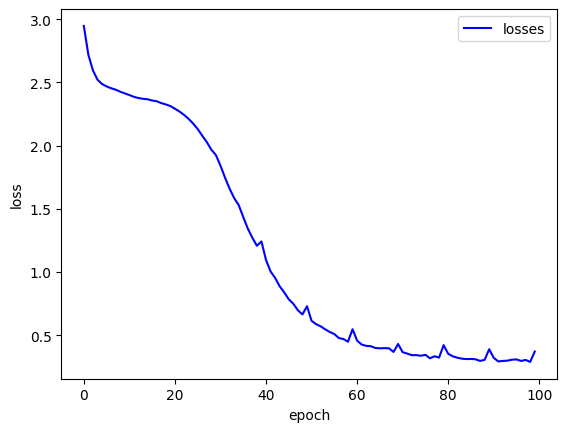

In [25]:
plot_losses(lstm_sh_losses)

## Report

According to the texts generated from different models and the losses during the training process of the models, analyze what is the reason for the difference in the result of models.

Which model works better and what do you think are the reasons?

<font color='#73FF73'><b>Your answer : </b></font>

After examining the generated text and the loss values, it’s clear that the LSTM model has outperformed the RNN model in this task. The LSTM model has generated more coherent and grammatically correct sentences compared to the RNN model. This is likely due to the LSTM’s ability to better capture long-term dependencies in the text, which is crucial for generating meaningful sentences.

In terms of the loss values, The LSTM model actually converges, and the loss function curve is very decent, indicating that it has learned the patterns in the data more effectively. This is consistent with our understanding of LSTMs as they are known to be more effective at learning from long sequences of data and are less prone to issues like vanishing gradients that can hinder the learning process in RNNs. On the other hand, the RNN model doesn't appear to converge, and is stuck at the same loss for pretty much the holw training.

---
---

# 2. FineTuning

FineTuning is a technique used in neural network training where a pre-trained model is further trained on a new task or dataset. It allows us to leverage the knowledge and representations learned by a pre-trained model and adapt it to a specific task or domain.

In this exercise, we first train the models with a `wikipedia` dataset that contains english texts, then we fine-tune this pre-trained model again with the Shakespeare play dataset to check the effect of this method on different models.

## Load Wikipedia dataset

In [26]:
!wget https://s3.amazonaws.com/fast-ai-nlp/wikitext-2.tgz

--2023-12-08 16:02:08--  https://s3.amazonaws.com/fast-ai-nlp/wikitext-2.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.197.192, 52.217.134.200, 52.216.129.149, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.197.192|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4070055 (3.9M) [application/x-tar]
Saving to: ‘wikitext-2.tgz’

wikitext-2.tgz      100%[===================>]   3.88M  17.8MB/s    in 0.2s    

2023-12-08 16:02:09 (17.8 MB/s) - ‘wikitext-2.tgz’ saved [4070055/4070055]



In [27]:
!tar -xvzf '/content/wikitext-2.tgz' -C '/content/data'

wikitext-2/
wikitext-2/train.csv
wikitext-2/test.csv


In [28]:
!cat './data/wikitext-2/train.csv' | tr -d '\n' > ./data/wikitext.txt

## Preprocessing

In [29]:
def clean_wiki_data(data):
    repl=''
    data=re.sub('\(', repl, data)
    data=re.sub('\)', repl, data)
    for pattern in set(re.findall("=.*=",data)):
        data=re.sub(pattern, repl, data)
    for pattern in set(re.findall("<unk>",data)):
        data=re.sub(pattern,repl,data)
    for pattern in set(re.findall(r"[^\w ]", data)):
        repl=''
        if pattern=='-':
            repl=' '
        if pattern!='.' and pattern!="\'":
            data=re.sub("\\"+pattern, repl, data)

    return data

def load_data(filepath):
    f=open(filepath)
    return f.read()

In [30]:
wikidata=load_data("./data/wikitext.txt")
data=wikidata[:]
data=clean_wiki_data(data)
wikiPreprocessed_file = open("./data/wiki_preprocesed.txt", "w")
f = wikiPreprocessed_file.write(data)
wikiPreprocessed_file.close()

- Load data in amount of 50kb for finetuning

In [31]:
wi_data_file = "./data/wiki_preprocesed.txt"
wi_data = open(wi_data_file, 'r').read(50000)

In [32]:
wi_data = remove_extraneous_characters(wi_data.lower(), chars)
wi_data_size = len(wi_data)

wi_data = list(wi_data)
for i, ch in enumerate(wi_data):
    wi_data[i] = char_to_ix[ch]

wi_data = torch.tensor(wi_data).to(device)
wi_data = torch.unsqueeze(wi_data, dim=1)

In [33]:
wi_data

tensor([[27],
        [27],
        [27],
        ...,
        [20],
        [18],
        [19]], device='cuda:0')

## Pre-training by wikipedia dataset

### RNN

In [34]:
rnn_wi_losses = train_rnn(wi_data, wi_data_size, './model_wi_rnn.pth')

Epoch: 10 Loss: 2.9808685779571533
Train Sample +++++++++++++++++++++++++++++++++++++++++++++
usoen ul  manhothh ea atreegnt   o fherc c n i  reahuunn  isus ranc   ascefeln opokoniy seiose hi odntrdooheh. eoii a  ap asemneut ieyeacnoc r neonge eow arc  uca  adeachntcr   o hsewnmuarenrd sr  ns.h
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 20 Loss: 2.8779494762420654
Train Sample +++++++++++++++++++++++++++++++++++++++++++++
maih oiwebhorrg meiohhe  i mwriihdt ta.t esms ee afe  ck uc oie llthsr cvl  bi lydeahletiledoip iua ooenshne.ruatoeeh:erdhdsi rt e erc nid no   es ttttn ouoar too  r  eii  r  bisn endro teitharocgaeege
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 30 Loss: 2.9798264503479004
Train Sample +++++++++++++++++++++++++++++++++++++++++++++
 seaotecp htrsriote oa mrw  ef .hpmwhvnt ooo k lcbeaglioe ynronp   gneniryn w uce  hcheu o u se  aebnoa ruso yao wpdhgyla  o oostsrtn is   y traot t    hart  pirm ufpcoanhdo  yosoa nor f uhdr vdci

### LSTM

In [35]:
lstm_wi_losses = train_lstm(wi_data, wi_data_size, './model_wi_lstm.pth')

Epoch: 10 Loss: 2.552238702774048
Train Sample +++++++++++++++++++++++++++++++++++++++++++++
p hy  antofhintoungoue mas gangok routheliell a way onsin wigath d tin fthored t  iaceteph riens  trnbad in  ty ge walap ared vin lste lof  clofabowind ty er ccamitreith sched  me on g el ik d st  bite
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 20 Loss: 2.422379732131958
Train Sample +++++++++++++++++++++++++++++++++++++++++++++
uig t m  hedge cte ounfte icalivearkileteut tithedfonir amie por boure .  lioug n ig continthwa ature sive   sthe ard then  war liste bint t of  a tin onge inatin ler   . id w a d ndes  th thy af pn  t
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 30 Loss: 1.7747894525527954
Train Sample +++++++++++++++++++++++++++++++++++++++++++++
trs ced  . is d  the wh  m  a stinen mesthabersth fon thisthearmironty ape mof na pr llsoube . maithwhe he  ns o whe d   ald  gs . d .  . orelalglon n onthevicorug   wigepofints int lontsoup w ts in

## Finetuning by Shakespeare

- Define the following functions to use the previous model as a pre-trained model and fine-tunes it using Shakespeare's plays dataset with lower learning rate.

In [36]:
def finetune_rnn(data, data_size, model_save_file, model_pretrained_path):
    # RNN parameters
    hidden_size = 512
    num_layers = 6
    lr = 0.001
    epoch_num = 100
    losses = []

    model = RNN(vocab_size, vocab_size, hidden_size, num_layers).to(device)
    model.load_model(model_pretrained_path)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    min_loss = np.inf

    for epoch in range(epoch_num):
        loss = train_epoch(model, data, data_size, epoch, optimizer)
        losses.append(loss)

        if loss < min_loss:
            min_loss = loss
            model.save_model(model_save_file)

    return losses


In [37]:
def finetune_lstm(data, data_size, model_save_file, model_pretrained_path):
    # LSTM parameters
    hidden_size = 512
    num_layers = 3
    lr = 0.001
    epoch_num = 100
    losses = []

    model = LSTM(vocab_size, vocab_size, hidden_size, num_layers).to(device)
    model.load_model(model_pretrained_path)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    min_loss = np.inf

    for epoch in range(epoch_num):
        loss = train_epoch(model, data, data_size, epoch, optimizer)
        losses.append(loss)

        if loss < min_loss:
            min_loss = loss
            model.save_model(model_save_file)

    return losses


### RNN

In [38]:
rnn_sh_finetune_losses = finetune_rnn(sh_data, sh_data_size, './model_sh_finetune_rnn.pth', './model_wi_rnn.pth')

Epoch: 0 Loss: 4.488612174987793
Train Sample +++++++++++++++++++++++++++++++++++++++++++++
ahsaenssruw aoeircwiu nueiljtdt aar hayas mp  awr afeuo esi lwfpaoavl edt htk arehmhe iwtlb eie flsbto fso lt .sbit tos assne iih ego woahrlies e t o nudgeiy.tgaidsev tv roolns  h hoeoyodeti dastiejacf
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 10 Loss: 3.158306360244751
Train Sample +++++++++++++++++++++++++++++++++++++++++++++
utg s ehnfcus shshet
o team s r ramasrcenoa  enpcgwi fo
de:ohhdwihaild te sat  oda 
sa ettw e edoe dhprhrtmt hneso eadodcnifrlcvdr  ty
 ioootpk
ro ooict hs odlhsosi g srs atthi 
ssys r eea pfe esecfooa
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 20 Loss: 3.1615750789642334
Train Sample +++++++++++++++++++++++++++++++++++++++++++++
aall  hhadnendbhnswdotwpntnsitiamat  amoh 
 tnsiarsolhln.eded
t: 
tirartn 
 io
drhla onisf 
w y c
yttusttep iuengnoe toe
cso
oei
 oebtdafredehnfshlyei  fmaeceofsf
vi   lvoadea slvtrdiuhtaeetetbn
ava 

### LSTM

In [39]:
lstm_sh_finetune_losses = finetune_lstm(sh_data, sh_data_size, './model_sh_finetune_lstm.pth', './model_wi_lstm.pth')

Epoch: 0 Loss: 6.40651798248291
Train Sample +++++++++++++++++++++++++++++++++++++++++++++
folon win tonutras l be mechea imer f talode  de sth  won ouatrad femm  t  w termmbe  canchethetrik . len t ntuarest cicks tha . me th fr thenum twe . tisthanal  he    asio nd wit fo t totuns me myoron
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 10 Loss: 2.2214009761810303
Train Sample +++++++++++++++++++++++++++++++++++++++++++++
 wichotigcothdg
mof me

hatsousetyour us lid bus
no r
oo ti asoumer hat ar ghangirrthe ieebe g ci m. mato ge
ke e 
:kendviushadecusth n  teshe th am w witheg. fr s::
theasse g darcustore whot th t y th
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 20 Loss: 1.6465568542480469
Train Sample +++++++++++++++++++++++++++++++++++++++++++++
ce thind t co it cifauranen fle angom m wie ouman

withealethat wey
s:the
m t s:mavago isscolat send
me.
inhirdlt. con ousmconarevind pr a
cathe ius
e matuamem s thengyosey the tour

mord m


wey

ff

## Plotting Losses

In [40]:
def plot_losses_together(losses1, losses2):
    xpoints = np.array(range(len(losses1)))
    ypoints1 = np.array(losses1)
    ypoints2 = np.array(losses2)

    plt.plot(xpoints, ypoints1, color='blue',label='base_losses' )
    plt.plot(xpoints, ypoints2, color='red',label='finetune_losses' )
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

### RNN

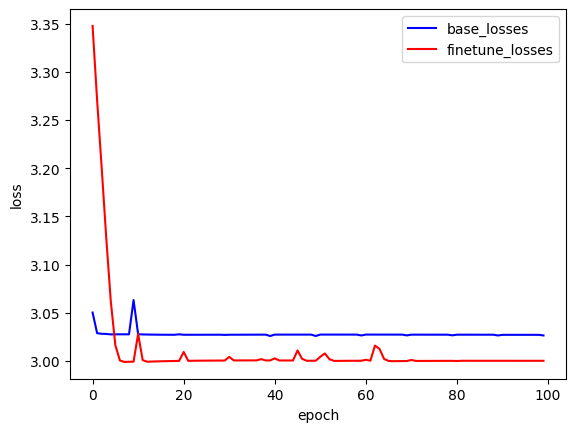

In [41]:
plot_losses_together(rnn_sh_losses, rnn_sh_finetune_losses)

### LSTM

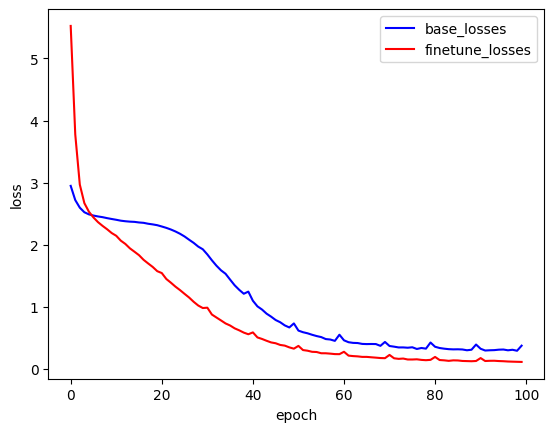

In [42]:
plot_losses_together(lstm_sh_losses, lstm_sh_finetune_losses)

## Report

As you can see, fine-tuning has an effect in improving the training of the main model.

By analyzing the obtained results, state the advantage of finetuning after pre-training the model by public dataset, and compare its performance in different models

<font color='#73FF73'><b>Your answer : </b></font>

From the loss plots, it’s evident that fine-tuning the models pre-trained on the Wikipedia dataset has led to an improvement in the performance on the Shakespeare dataset. The loss values for both the RNN and LSTM models have decreased more rapidly and reached lower values compared to training from scratch. This indicates that the models have benefited from the initial pre-training phase and were able to adapt more quickly to the new dataset.

The advantage of this fine-tuning approach is that the models can leverage the knowledge learned from a large and diverse dataset like Wikipedia, which can provide a good initialization of the model parameters. This can help the models to converge faster and achieve better performance when fine-tuned on a specific task or domain, such as generating text in the style of Shakespeare.

Comparing the performance of the RNN and LSTM models, it appears that the LSTM model has achieved a slightly lower loss value. This suggests that the LSTM model might be better at capturing the long-term dependencies in the text, which is crucial for generating coherent and grammatically correct sentences. However, both models have shown significant improvement with the fine-tuning approach, demonstrating the effectiveness of this technique in enhancing model performance.


----
----

# 3. Experiment on different datasets

In the previous section, you saw the performance results of the text generation model using the Shakespeare plays dataset. In the following, you will check the results of the LSTM model on the dialogues of the `Friends series`

## Load dataset

In [43]:
!wget https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-09-08/friends.csv -O ./data/Friends.csv

--2023-12-08 16:09:20--  https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-09-08/friends.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5383844 (5.1M) [text/plain]
Saving to: ‘./data/Friends.csv’

./data/Friends.csv  100%[===================>]   5.13M  --.-KB/s    in 0.08s   

2023-12-08 16:09:20 (63.8 MB/s) - ‘./data/Friends.csv’ saved [5383844/5383844]



## preprocessing

In [44]:
friends = pd.read_csv('./data/Friends.csv')
friends = friends.dropna()
friends = friends[friends['speaker'].str.contains('SCENE')==False]
friends['speaker'] = friends['speaker'].apply(lambda sp: sp.lower().capitalize().split(' ')[0])
friends_texts = friends.drop(['episode','season','scene','utterance'], axis='columns')
friends_texts.head()

,text,speaker
0,There's nothing to tell! He's just some guy I ...,Monica
1,"C'mon, you're going out with the guy! There's ...",Joey
2,"All right Joey, be nice. So does he have a hum...",Chandler
3,"Wait, does he eat chalk?",Phoebe
4,"(They all stare, bemused.)",Scene


In [45]:
f = open("./data/fiends.txt", "w")
for i,row in friends_texts.iterrows():
    f.write(row['speaker'] + ':\n' + row['text'] + '\n\n')

f.close()

In [46]:
fr_data_file = "./data/fiends.txt"
fr_data = open(fr_data_file, 'r').read(30000)
fr_data = remove_extraneous_characters(fr_data.lower(), chars)
fr_data_size = len(fr_data)

fr_data = list(fr_data)
for i, ch in enumerate(fr_data):
    fr_data[i] = char_to_ix[ch]

fr_data = torch.tensor(fr_data).to(device)
fr_data = torch.unsqueeze(fr_data, dim=1)

## Train finetuned LSTM by friends dataset

In [47]:
lstm_fr_finetune_losses = finetune_lstm(fr_data, fr_data_size, './model_fr_lstm.pth', './model_wi_lstm.pth')

Epoch: 0 Loss: 5.465887546539307
Train Sample +++++++++++++++++++++++++++++++++++++++++++++
mvily ower  sprevit win ung mofrermp . acoflon t t thewey t  ived t merion rk . leey  cheffond llbeasoorutings  m oprit st   asece tincseeede buare m le  d mepas sth f t   ter ca cute a re  the   iorer
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 10 Loss: 2.1353859901428223
Train Sample +++++++++++++++++++++++++++++++++++++++++++++
lllllyouni s...
st s ho.... m mmo warangtexer. el:ysinishtchomo oundouse r.



:nenowetig his y thacaurrt the toar chem dlleoelidant htou wh yor justhaysodss our menooutatarshe he... hahanouculy tice w
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 20 Loss: 1.4893335103988647
Train Sample +++++++++++++++++++++++++++++++++++++++++++++
ngond...r:
ha snnosu we be fe be:
r..... thichangon ilinblel ldini





wicari the

myoullyoulithon h belidiss o theat tod befan t wes yont ba ohe

wo s ig a berilit


auth wisicambeliclingo:





l

## Generating texts

In [48]:
best_model_lstm =  LSTM(vocab_size, vocab_size, 512, 3).to(device)
best_model_lstm.load_model('./model_fr_lstm.pth')
print("best loss", min(lstm_fr_finetune_losses))
generate_text(best_model_lstm, fr_data, fr_data_size)

best loss 0.10585042816046235
Eaxmple of generated text --------------------------------------------------------------------------
neant chevebbelufl:jouthith irene anoum icoud odlw ce i k me t ndin int o h f i k icont o y us idoe l g iced mellese tininindnom icu urelyeres.


res s ha l d inigayout
youl... bath t at p ll:
o greve...on ugougoes:







mes d ha...




rem eangos:



r t achacad it ur anohanta whe m nd m is... g arayoowhohanthath toethay wond ise y anne hents hey momoknereb
yobe indlly ay bavayetouraveolintsou ait alicahanchentakne ind ge knsha ch fed ar ralopodorayo aracas caleyoll. whur t hitth oso.


me it l to t g g wemblla youdni...... d h w yoff lou ere g tican uy y rat chthesties l:
ous o ththestolave. t ts ith t carer:
a:

ri be:ofe:
rabelere wa ismindy h icanthof tand gare inonth

ral de
jundo thaha:
oes t eat h ican leysoudan. m ntsanoour:
omeen
y y fl od at m.. itsh
m tane a k

ravey mm ad hacay.. g w
st im at od sheonkiniss thaha:







h widcey mas weosnde 

- As you can see, the LSTM network has been able to learn the features of different datasets in terms of sentence length and writing style and use it in text generation.

## The output of finetuned models on different datasets on the input sample

- In this section, you can see the result of the text generated by models with a sample input text.

In [49]:
input_sample_text = "Hello, have a nice day.\n"

In [50]:
best_model_lstm =  LSTM(vocab_size, vocab_size, 512, 3).to(device)
best_model_lstm.load_model('./model_fr_lstm.pth')
generate_text(best_model_lstm, fr_data, fr_data_size, create_input_sample_dataset(input_sample_text),100)

Eaxmple of generated text --------------------------------------------------------------------------
s thi intcheos

cale ig bboad heere ad t ch we ou ous tin int tourav t icadohe ont o charer:
o offo t
----------------------------------------------------------------------------------------------------


In [51]:
best_model_lstm =  LSTM(vocab_size, vocab_size, 512, 3).to(device)
best_model_lstm.load_model('./model_sh_finetune_lstm.pth')
generate_text(best_model_lstm, sh_data, sh_data_size, create_input_sample_dataset(input_sample_text),100)

Eaxmple of generated text --------------------------------------------------------------------------
we thow i iush thout owathof ic nd iutous whindyob is woucids:

sied
that wike s ama:
d pre y ciuse t
----------------------------------------------------------------------------------------------------


## Report

According to the sample input and output produced by the fine-tuned model with the Shakespeare dataset and the Friends dataset, which output is more meaningful and what is the reason for this difference?

<font color='#73FF73'><b>Your answer : </b></font>

Based on the nature of the datasets, it’s likely that the output from the model fine-tuned on the Friends dataset would be more meaningful in a modern context. The Friends dataset consists of dialogues from a contemporary TV show, which is likely to contain everyday language and scenarios that are more relatable and understandable to a modern audience.

On the other hand, while the output from the model fine-tuned on the Shakespeare dataset might be more poetic and complex, it could also be more difficult to understand due to the archaic language and intricate expressions characteristic of Shakespeare’s works.

Therefore, if we consider “meaningful” as being easily understood and relatable, the model fine-tuned on the Friends dataset has produced more meaningful output. However, it’s important to note that the definition of “meaningful” can vary depending on the context and the specific requirements of the task. For a task requiring a more artistic and poetic style, the model fine-tuned on the Shakespeare dataset might be more suitable.


----
----